# Waveform Noise2Noise (1D) Tutorial

This notebook shows how to:
- Load 1D waveforms from a `.npy` or `.npz` file
- Load a trained Noise2Noise1D model and scalers
- Denoise waveforms and plot Original vs Denoised per event/channel

Prereq: Train the model with `scripts/train_waveforms.py` and keep the output dir (weights + scalers).


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from joblib import load

import n2n
from n2n import Noise2Noise1DTCN, denoise_waveforms
from n2n.model_functions import check_available_device

In [4]:
# Configure your data/model paths here
WAVE_PATH = "/pscratch/sd/h/haeun/TB2025/run_12185_merged.npz"  # or .npz with key 'waves_tower'
OUT_DIR   = "../output"            # directory where training saved weights/scalers

# Optional: selection and streaming to save memory
SELECT_CHANNEL_NAMES  = ["M4T2S"]   # names: e.g., ["M1T1S", "M1T1C", "C1"]
# EVENT_SLICE can be: None, slice(start, stop), (start, stop), or an int (single event)
EVENT_SLICE           = (0, 1000)
CHUNK_EVENTS          = None   # e.g., 64 to stream by event chunks (recommended for huge files)

# Plot controls
PLOT_EVENT_IDX    = 0      # which event to show
PLOT_CHANNEL_IDX  = 0      # which channel index within the selected set
PLOT_CHANNEL_NAME = None   # optional: channel name (must be in SELECT_CHANNEL_NAMES)
PLOT_YLIM         = (-100, 20)   # e.g., (-100, 50) or None for auto

# Residual+N2N inference: denoise_waveforms will use target_scaler and return raw units.

In [5]:
# Load waveforms with optional selection/streaming and name-based channel filtering

# Resolve channel indices only from channel names in NPZ metadata

def _resolve_channel_indices_npz(meta_channel_names, select_names):
    if select_names is None:
        return None
    name_to_idx = {str(n): i for i, n in enumerate(meta_channel_names)}
    indices = []
    for nm in select_names:
        if nm not in name_to_idx:
            raise KeyError(f"Channel name not found in NPZ: {nm}")
        indices.append(name_to_idx[nm])
    # deduplicate while preserving order
    if not indices:
        return None
    indices = list(dict.fromkeys(indices))
    return np.asarray(indices)

CH_INDEX = None  # unified channel index selection for downstream cells
CH_NAMES_SEL = None  # selected channel names aligned to CH_INDEX
SEL_E = None  # selected num events
SEL_C = None  # selected num channels

if WAVE_PATH.endswith('.npz'):
    data = np.load(WAVE_PATH)
    full = data['waves_tower']  # defer astype until after slicing to save memory
    meta_channel_names = data.get('channel_names', None)
    if meta_channel_names is not None:
        meta_channel_names = meta_channel_names.astype(str)
        CH_INDEX = _resolve_channel_indices_npz(
            meta_channel_names,
            SELECT_CHANNEL_NAMES,
        )
        if CH_INDEX is not None:
            CH_NAMES_SEL = meta_channel_names[CH_INDEX]
    if full.ndim == 3:
        E, C, L = full.shape
        # Normalize EVENT_SLICE which can be None, slice, tuple(start, stop), or int
        if isinstance(EVENT_SLICE, tuple) and len(EVENT_SLICE) == 2:
            ev_idx = slice(EVENT_SLICE[0], EVENT_SLICE[1])
        elif isinstance(EVENT_SLICE, int):
            ev_idx = slice(EVENT_SLICE, EVENT_SLICE + 1)
        else:
            ev_idx = EVENT_SLICE if EVENT_SLICE is not None else slice(None)
        ch_idx = CH_INDEX if CH_INDEX is not None else slice(None)
        sub = full[ev_idx, ch_idx, :]
        SEL_E = sub.shape[0]
        SEL_C = sub.shape[1]
        if CHUNK_EVENTS is None:
            sub = sub.astype(np.float32)
            X = sub.reshape(-1, sub.shape[-1])
        else:
            X = None  # will stream later in denoise block
    elif full.ndim == 2:
        E = C = 0
        L = full.shape[1]
        sub = full.astype(np.float32)
        X = sub
    else:
        raise ValueError(f"Unsupported waves_tower shape: {full.shape}")
else:
    full = np.load(WAVE_PATH, mmap_mode='r')  # use memmap if possible
    if full.ndim == 3:
        E, C, L = full.shape
        # Normalize EVENT_SLICE which can be None, slice, tuple(start, stop), or int
        if isinstance(EVENT_SLICE, tuple) and len(EVENT_SLICE) == 2:
            ev_idx = slice(EVENT_SLICE[0], EVENT_SLICE[1])
        elif isinstance(EVENT_SLICE, int):
            ev_idx = slice(EVENT_SLICE, EVENT_SLICE + 1)
        else:
            ev_idx = EVENT_SLICE if EVENT_SLICE is not None else slice(None)
        ch_idx = slice(None)  # raw NPY has no names; select all channels
        sub = full[ev_idx, ch_idx, :]
        SEL_E = sub.shape[0]
        SEL_C = sub.shape[1]
        if CHUNK_EVENTS is None:
            sub = np.asarray(sub, dtype=np.float32)
            X = sub.reshape(-1, sub.shape[-1])
        else:
            X = None
    elif full.ndim == 2:
        E = C = 0
        L = full.shape[1]
        sub = np.asarray(full, dtype=np.float32)
        X = sub
    else:
        raise ValueError(f"Unsupported array shape: {full.shape}")

if X is not None:
    print('Loaded waveforms:', X.shape, '(flattened 2D)')
else:
    # streaming mode
    num_events_selected = (sub.shape[0] if sub.ndim == 3 else 1)
    num_channels_selected = (sub.shape[1] if sub.ndim == 3 else 1)
    print(f'Streaming mode: E={num_events_selected}, C={num_channels_selected}, L={L}, chunk_events={CHUNK_EVENTS}')



Loaded waveforms: (1000, 1000) (flattened 2D)


In [6]:
# Load model and scalers
fscaler = load(f"{OUT_DIR}/waveform_feature_scaler.joblib")
try:
    tscaler = load(f"{OUT_DIR}/waveform_target_scaler.joblib")
except Exception:
    tscaler = None

# TCN-based Noise2Noise model (1D)
# Default channels give receptive field ~511 for kernel_size=3; adjust if needed
model = Noise2Noise1DTCN(in_channels=1, num_channels=None, kernel_size=3, dropout=0.1)
state = torch.load(f"{OUT_DIR}/waveform_n2n_weights.pt", map_location=torch.device(check_available_device()))
if any(k.startswith('module.') for k in state.keys()):
    state = {k.replace('module.', ''): v for k, v in state.items()}
model.load_state_dict(state); model.eval()
model.to(torch.device(check_available_device()))
print('Model loaded')



Model loaded


In [7]:
# Denoise (supports streaming by events to reduce memory)
# Residual+N2N inference: pass target_scaler so outputs are in raw units (y_hat = x_raw - r_raw)
if X is not None:
    # Normal path (array already materialized)
    preds = denoise_waveforms(X, fscaler, model, batch_size=1024, target_scaler=tscaler)
else:
    # Streaming path: iterate over event chunks to limit peak memory
    assert CHUNK_EVENTS is not None and isinstance(CHUNK_EVENTS, int) and CHUNK_EVENTS > 0
    ev_idx = EVENT_SLICE if EVENT_SLICE is not None else slice(None)
    ch_idx = CH_INDEX if CH_INDEX is not None else slice(None)
    # sub has shape (E_sel, C_sel, L)
    E_sel = sub.shape[0]; C_sel = sub.shape[1]
    preds_list = []
    for start in range(0, E_sel, CHUNK_EVENTS):
        stop = min(start + CHUNK_EVENTS, E_sel)
        chunk = np.asarray(sub[start:stop, ch_idx, :], dtype=np.float32)
        chunk2d = chunk.reshape(-1, L)
        chunk_raw = denoise_waveforms(chunk2d, fscaler, model, batch_size=1024, target_scaler=tscaler)
        preds_list.append(chunk_raw)
    preds = np.concatenate(preds_list, axis=0)
print('Denoised:', preds.shape)



Denoised: (1000, 1000)


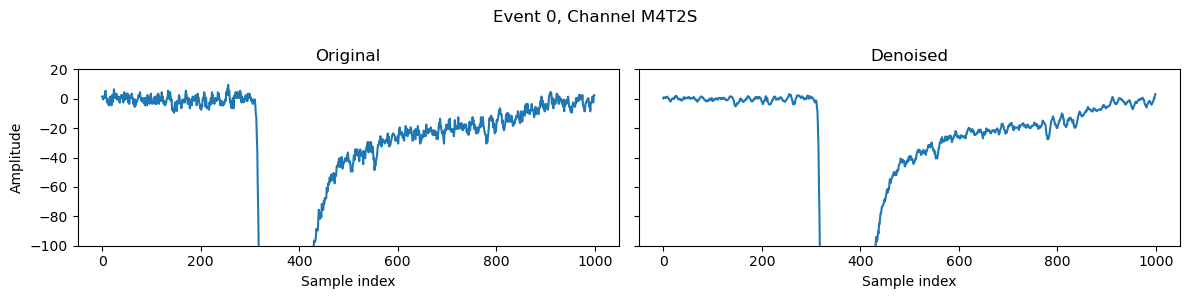

In [8]:
# Plot one waveform side-by-side (Original left, Denoised right)
# Prefer selected channels: use PLOT_CHANNEL_NAME if provided; else
# if only one channel selected, use that; else fallback to PLOT_CHANNEL_IDX.

def _resolve_plot_channel_index():
    # Prefer explicit channel name
    if 'PLOT_CHANNEL_NAME' in globals() and PLOT_CHANNEL_NAME:
        if 'CH_NAMES_SEL' in globals() and CH_NAMES_SEL is not None:
            matches = np.where(CH_NAMES_SEL == PLOT_CHANNEL_NAME)[0]
            if len(matches) == 0:
                raise KeyError(f"PLOT_CHANNEL_NAME '{PLOT_CHANNEL_NAME}' not in selected channel names")
            return int(matches[0])
    # Single selected channel -> use index 0
    if 'SEL_C' in globals() and SEL_C is not None and int(SEL_C) == 1:
        return 0
    # Fallback to provided channel index
    return int(PLOT_CHANNEL_IDX) if 'PLOT_CHANNEL_IDX' in globals() else 0

if (X is not None) and ('SEL_E' in globals()) and ('SEL_C' in globals()) and (SEL_E is not None) and (SEL_C is not None) and (int(SEL_E) * int(SEL_C) == len(X)):
    # Flattened path with known selected dims
    E_sel, C_sel = int(SEL_E), int(SEL_C)
    X_ecl = X.reshape(E_sel, C_sel, L)
    Y_ecl = preds.reshape(E_sel, C_sel, L)
    e_idx = int(PLOT_EVENT_IDX) if 'PLOT_EVENT_IDX' in globals() else 0
    c_idx = _resolve_plot_channel_index()
    orig = X_ecl[e_idx, c_idx]
    deno = Y_ecl[e_idx, c_idx]
    ch_label = (CH_NAMES_SEL[c_idx] if ('CH_NAMES_SEL' in globals() and CH_NAMES_SEL is not None) else str(c_idx))
    title = f"Event {e_idx}, Channel {ch_label}"
elif X is not None:
    # Simple 2D case (no channel dimension)
    n_idx = int(PLOT_EVENT_IDX) if 'PLOT_EVENT_IDX' in globals() else 0
    orig = X[n_idx]
    deno = preds[n_idx]
    title = f"Sample {n_idx}"
else:
    # Streaming mode: use sub shaped (SEL_E, SEL_C, L)
    E_sel = int(SEL_E) if ('SEL_E' in globals() and SEL_E is not None) else sub.shape[0]
    C_sel = int(SEL_C) if ('SEL_C' in globals() and SEL_C is not None) else sub.shape[1]
    Y_ecl = preds.reshape(E_sel, C_sel, L)
    e_idx = int(PLOT_EVENT_IDX) if 'PLOT_EVENT_IDX' in globals() else 0
    c_idx = _resolve_plot_channel_index()
    orig = np.asarray(sub[e_idx, c_idx], dtype=np.float32)
    deno = Y_ecl[e_idx, c_idx]
    ch_label = (CH_NAMES_SEL[c_idx] if ('CH_NAMES_SEL' in globals() and CH_NAMES_SEL is not None) else str(c_idx))
    title = f"Event {e_idx}, Channel {ch_label}"

fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharey=True)
axes[0].plot(orig)
axes[0].set_title("Original")
axes[0].set_xlabel("Sample index"); axes[0].set_ylabel("Amplitude")
axes[1].plot(deno)
axes[1].set_title("Denoised")
axes[1].set_xlabel("Sample index")

# Apply y-limits if provided
if 'PLOT_YLIM' in globals() and PLOT_YLIM is not None:
    ymin, ymax = PLOT_YLIM
    axes[0].set_ylim(ymin, ymax)
    axes[1].set_ylim(ymin, ymax)

fig.suptitle(title)
fig.tight_layout()
plt.show()

